# EDA анализ EURUSD данных (2010-2024)

## Цель анализа
Провести комплексный исследовательский анализ данных (EDA) для валютной пары EUR/USD за период 2010-2024 годы с почасовой детализацией.

## План анализа
1. **Структура и базовая статистика** - изучение формата данных, пропусков, основных метрик
2. **Анализ волатильности и доходностей** - изменчивость цен, статистические характеристики
3. **Корреляционный анализ** - взаимосвязи между ценами и предсказуемость
4. **Анализ сезонности и временных паттернов** - поведение по часам, дням недели, месяцам
5. **Детекция аномалий и выбросов** - поиск необычных значений
6. **Анализ объёмов** - если доступны данные о торговых объёмах
7. **Дополнительный анализ** - технические индикаторы, особенности рынка

## 📚 Словарь терминов

**Стандартное отклонение (std)** - мера разброса данных относительно среднего значения. Чем больше std, тем более "разбросаны" цены.

**Доходность (returns)** - процентное изменение цены от одного периода к другому. Формула: (Цена_новая - Цена_старая) / Цена_старая

**Волатильность** - мера "нестабильности" цены. Высокая волатильность = большие колебания цен.

**Автокорреляция** - связь значения с самим собой в прошлом. Показывает, влияет ли вчерашняя доходность на сегодняшнюю.

**Выбросы** - экстремально большие или маленькие значения, которые сильно отличаются от остальных данных.

**ANOVA тест** - статистический метод, который проверяет, есть ли значимые различия между группами (например, между разными часами дня).

**IQR метод** - способ поиска выбросов: если значение выходит за границы "нормального" диапазона, оно считается выбросом.


In [6]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import scipy.stats as stats
import sys
from pathlib import Path

# Добавляем путь к модулям проекта
project_root = Path.cwd().parent.parent
utils_path = project_root / "03_src"
sys.path.insert(0, str(utils_path))

# Проверяем, что файл существует
report_gen_path = utils_path / "utils" / "report_generator.py"
print(f"Путь к модулю: {report_gen_path}")
print(f"Файл существует: {report_gen_path.exists()}")

# Импортируем наш модуль для создания отчетов
from utils.report_generator import EDAReportGenerator, save_figure_to_report, add_analysis_section  # type: ignore

# Настройки визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Настройки pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)

# Инициализируем генератор отчетов
report = EDAReportGenerator(project_root=project_root)

# Добавляем заголовок отчета
report.add_header("EDA анализ EURUSD данных (2010-2024)", level=1)
report.add_text("Автоматически сгенерированный отчет exploratory data analysis для валютной пары EUR/USD.")

print("✅ Библиотеки успешно загружены!")
print(f"📊 Генератор отчетов инициализирован. Папка для сохранения: {report.interim_dir}")
print(f"🖼️ Изображения будут сохраняться в: {report.images_dir}")


Путь к модулю: c:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\03_src\utils\report_generator.py
Файл существует: True
✅ Библиотеки успешно загружены!
📊 Генератор отчетов инициализирован. Папка для сохранения: c:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\interim
🖼️ Изображения будут сохраняться в: c:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\interim\images


## 1. Загрузка и первичное изучение данных


In [7]:
# Загрузка данных
data_path = r"C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\raw\EURUSD_2010-2024_H1_OANDA.csv"

# Загружаем данные
df = pd.read_csv(data_path)

print("=== ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ ===")
print(f"Размер датасета: {df.shape}")
print(f"Размер в памяти: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n=== ПЕРВЫЕ 5 СТРОК ===")
print(df.head())
print("\n=== ПОСЛЕДНИЕ 5 СТРОК ===")
print(df.tail())
print("\n=== ИНФОРМАЦИЯ О КОЛОНКАХ ===")
print(df.info())
print("\n=== НАЗВАНИЯ КОЛОНОК ===")
print(df.columns.tolist())


=== ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ ===
Размер датасета: (88630, 6)
Размер в памяти: 9.64 MB

=== ПЕРВЫЕ 5 СТРОК ===
                        time     open     high      low    close  volume
0  2010-01-03 17:00:00+00:00 1.431200 1.431720 1.431200 1.431720       3
1  2010-01-03 18:00:00+00:00 1.431720 1.434250 1.431050 1.431570     137
2  2010-01-03 19:00:00+00:00 1.431540 1.432120 1.430810 1.431060     299
3  2010-01-03 20:00:00+00:00 1.431030 1.432010 1.430760 1.430800     261
4  2010-01-03 21:00:00+00:00 1.430780 1.431140 1.429260 1.430360     327

=== ПОСЛЕДНИЕ 5 СТРОК ===
                            time     open     high      low    close  volume
88625  2023-12-29 17:00:00+00:00 1.106070 1.106690 1.105290 1.106430    4230
88626  2023-12-29 18:00:00+00:00 1.106410 1.106410 1.104930 1.105320    5238
88627  2023-12-29 19:00:00+00:00 1.105300 1.105400 1.103820 1.104100    2778
88628  2023-12-29 20:00:00+00:00 1.104110 1.105100 1.103840 1.104110    2265
88629  2023-12-29 21:00:00+00:00 1.10

In [8]:
# Обработка даты и времени
# Автоматически определяем колонку с временем
datetime_col = None
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['time', 'date', 'datetime']):
        datetime_col = col
        break

if datetime_col is None:
    datetime_col = df.columns[0]  # Предполагаем, что первая колонка - это дата

print(f"Используем колонку '{datetime_col}' как временную метку")

# Конвертируем в datetime и убираем timezone (+00:00)
df[datetime_col] = pd.to_datetime(df[datetime_col], utc=True).dt.tz_localize(None)
df.set_index(datetime_col, inplace=True)

print("\n=== ИНФОРМАЦИЯ О ВРЕМЕННОМ ДИАПАЗОНЕ ===")
print(f"Период данных: с {df.index.min().strftime('%Y-%m-%d %H:%M')} по {df.index.max().strftime('%Y-%m-%d %H:%M')}")
print(f"Количество лет: {(df.index.max() - df.index.min()).days / 365.25:.1f}")


Используем колонку 'time' как временную метку

=== ИНФОРМАЦИЯ О ВРЕМЕННОМ ДИАПАЗОНЕ ===
Период данных: с 2010-01-03 17:00 по 2023-12-29 21:00
Количество лет: 14.0


In [9]:
# Определяем колонки OHLCV (Open, High, Low, Close, Volume)
price_cols = []
for col in df.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['open', 'high', 'low', 'close']):
        price_cols.append(col)

volume_cols = [col for col in df.columns if 'volume' in col.lower()]

print("=== ИДЕНТИФИКАЦИЯ КОЛОНОК ===")
print(f"Ценовые колонки: {price_cols}")
print(f"Колонки объёмов: {volume_cols}")
print(f"Все колонки: {df.columns.tolist()}")

print("\n=== БАЗОВАЯ СТАТИСТИКА ===")
print(df.describe())

print("\n=== ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===")
missing_data = df.isnull().sum()
total_missing = missing_data.sum()

if total_missing == 0:
    print("✓ Пропущенных значений не обнаружено!")
else:
    print(f"⚠️  Обнаружено пропущенных значений:")
    for col, count in missing_data[missing_data > 0].items():
        percent = (count / len(df)) * 100
        print(f"  {col}: {count} ({percent:.2f}%)")
    
print("\n=== ПРОВЕРКА ДУБЛИКАТОВ ВРЕМЕННЫХ МЕТОК ===")
# Проверяем дублирующиеся даты/времена (индекс)
duplicate_times = df.index.duplicated().sum()
print(f"Количество дублирующихся временных меток: {duplicate_times}")

if duplicate_times > 0:
    print("⚠️  Найдены дублирующиеся временные метки! Возможные причины:")
    print("  - Повторная загрузка данных за одни и те же периоды")
    print("  - Перекрытие в источнике данных")
    print("  - Ошибки при переходе на летнее/зимнее время")
    
    # Покажем примеры дублирующихся временных меток
    duplicate_indices = df.index[df.index.duplicated(keep=False)]
    if len(duplicate_indices) > 0:
        print(f"\nПримеры дублирующихся временных меток:")
        unique_duplicates = duplicate_indices.unique()[:5]  # Показываем первые 5 уникальных дублирующихся дат
        for dup_time in unique_duplicates:
            count = (df.index == dup_time).sum()
            print(f"  {dup_time.strftime('%Y-%m-%d %H:%M')}: встречается {count} раз")
else:
    print("✓ Дублирующихся временных меток не обнаружено!")

# Сохраняем статистическую сводку в отчет
report.add_statistics_summary(df, "1. Структура и базовая статистика")

# Добавляем дополнительную информацию о качестве данных
data_quality_info = f"""
**Качество данных:**
- Пропущенные значения: {df.isnull().sum().sum()} (0%)
- Дублирующиеся временные метки: {duplicate_times}
- Временной период: {(df.index.max() - df.index.min()).days} дней
- Частота данных: Почасовая (H1)
"""
report.add_text(data_quality_info)


=== ИДЕНТИФИКАЦИЯ КОЛОНОК ===
Ценовые колонки: ['open', 'high', 'low', 'close']
Колонки объёмов: ['volume']
Все колонки: ['open', 'high', 'low', 'close', 'volume']

=== БАЗОВАЯ СТАТИСТИКА ===
              open         high          low        close       volume
count 88630.000000 88630.000000 88630.000000 88630.000000 88630.000000
mean      1.200950     1.201822     1.200093     1.200948  2574.674907
std       0.115808     0.115906     0.115704     0.115805  2890.258599
min       0.953960     0.955960     0.953600     0.953940     1.000000
25%       1.107840     1.108480     1.107220     1.107840   768.250000
50%       1.173815     1.174480     1.173210     1.173815  1653.000000
75%       1.306598     1.307440     1.305680     1.306580  3320.750000
max       1.493390     1.494020     1.490540     1.493360 53617.000000

=== ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===
✓ Пропущенных значений не обнаружено!

=== ПРОВЕРКА ДУБЛИКАТОВ ВРЕМЕННЫХ МЕТОК ===
Количество дублирующихся временных меток: 0
✓ Д

## 2. Анализ волатильности и доходностей


In [10]:
# Расчет доходностей и волатильности
def calculate_returns_and_volatility(data, price_col):
    """Рассчитывает различные виды доходностей и волатильности"""
    
    # Простые доходности
    data['returns'] = data[price_col].pct_change()
    
    # Логарифмические доходности
    data['log_returns'] = np.log(data[price_col] / data[price_col].shift(1))
    
    # Скользящая волатильность (20 периодов)
    data['volatility_20'] = data['returns'].rolling(window=20).std() * np.sqrt(24)  # Годовая волатильность
    
    # Высоко-низкая волатильность (если есть High и Low)
    high_col = next((col for col in data.columns if 'high' in col.lower()), None)
    low_col = next((col for col in data.columns if 'low' in col.lower()), None)
    
    if high_col and low_col:
        data['hl_volatility'] = np.log(data[high_col] / data[low_col])
    
    return data

# Находим колонку с ценой закрытия
close_col = next((col for col in df.columns if 'close' in col.lower()), df.columns[-1])
print(f"Используем колонку '{close_col}' как цену закрытия")

# Применяем расчеты
df = calculate_returns_and_volatility(df, close_col)

print("\n=== ПРОСТАЯ СТАТИСТИКА ИЗМЕНЕНИЙ ЦЕН ===")

# Преобразуем в более понятные единицы
hourly_return_pct = df['returns'].mean() * 100  # в процентах
daily_return_pct = df['returns'].mean() * 24 * 100  # дневная доходность
annual_return_pct = df['returns'].mean() * 24 * 365 * 100  # годовая

print(f"Среднее изменение цены за час: {hourly_return_pct:.4f}%")
print(f"Среднее изменение цены за день: {daily_return_pct:.4f}%") 
print(f"Среднее изменение цены за год: {annual_return_pct:.2f}%")

print(f"\nВолатильность (размах колебаний):")
print(f"Часовая волатильность: {df['returns'].std() * 100:.4f}%")
print(f"Дневная волатильность: {df['returns'].std() * np.sqrt(24) * 100:.4f}%")
print(f"Годовая волатильность: {df['returns'].std() * np.sqrt(24 * 365) * 100:.2f}%")

# Простая статистика направления движения
positive_returns = (df['returns'] > 0).sum()
negative_returns = (df['returns'] < 0).sum()
zero_returns = (df['returns'] == 0).sum()

print(f"\n=== НАПРАВЛЕНИЕ ДВИЖЕНИЯ ЦЕН ===")
print(f"Часов с ростом цены: {positive_returns} ({positive_returns/len(df)*100:.1f}%)")
print(f"Часов с падением цены: {negative_returns} ({negative_returns/len(df)*100:.1f}%)")
print(f"Часов без изменений: {zero_returns} ({zero_returns/len(df)*100:.1f}%)")

# Экстремальные движения в понятных единицах
max_growth = df['returns'].max() * 100
max_decline = df['returns'].min() * 100
max_growth_date = df['returns'].idxmax()
max_decline_date = df['returns'].idxmin()

print(f"\n=== ЭКСТРЕМАЛЬНЫЕ ДВИЖЕНИЯ ===")
print(f"Максимальный рост за час: {max_growth:.4f}% ({max_growth_date.strftime('%Y-%m-%d %H:%M')})")
print(f"Максимальное падение за час: {max_decline:.4f}% ({max_decline_date.strftime('%Y-%m-%d %H:%M')})")

# Что значат эти числа для трейдера
print(f"\n=== ЧТО ЭТО ОЗНАЧАЕТ ДЛЯ ТРЕЙДИНГА ===")
if abs(annual_return_pct) < 5:
    trend_assessment = "Слабый тренд"
elif abs(annual_return_pct) < 15:
    trend_assessment = "Умеренный тренд" 
else:
    trend_assessment = "Сильный тренд"

annual_vol = df['returns'].std() * np.sqrt(24 * 365) * 100
if annual_vol < 10:
    vol_assessment = "Низкая волатильность"
elif annual_vol < 20:
    vol_assessment = "Умеренная волатильность"
else:
    vol_assessment = "Высокая волатильность"

print(f"Характер рынка: {trend_assessment}, {vol_assessment.lower()}")
print(f"Среднее движение за день ~{abs(daily_return_pct):.3f}%, что {'благоприятно' if abs(daily_return_pct) > 0.1 else 'неблагоприятно'} для внутридневной торговли")


Используем колонку 'close' как цену закрытия

=== ПРОСТАЯ СТАТИСТИКА ИЗМЕНЕНИЙ ЦЕН ===
Среднее изменение цены за час: -0.0002%
Среднее изменение цены за день: -0.0056%
Среднее изменение цены за год: -2.03%

Волатильность (размах колебаний):
Часовая волатильность: 0.1107%
Дневная волатильность: 0.5423%
Годовая волатильность: 10.36%

=== НАПРАВЛЕНИЕ ДВИЖЕНИЯ ЦЕН ===
Часов с ростом цены: 43618 (49.2%)
Часов с падением цены: 43510 (49.1%)
Часов без изменений: 1501 (1.7%)

=== ЭКСТРЕМАЛЬНЫЕ ДВИЖЕНИЯ ===
Максимальный рост за час: 1.7439% (2022-11-10 13:00)
Максимальное падение за час: -2.0280% (2016-06-24 02:00)

=== ЧТО ЭТО ОЗНАЧАЕТ ДЛЯ ТРЕЙДИНГА ===
Характер рынка: Слабый тренд, умеренная волатильность
Среднее движение за день ~0.006%, что неблагоприятно для внутридневной торговли


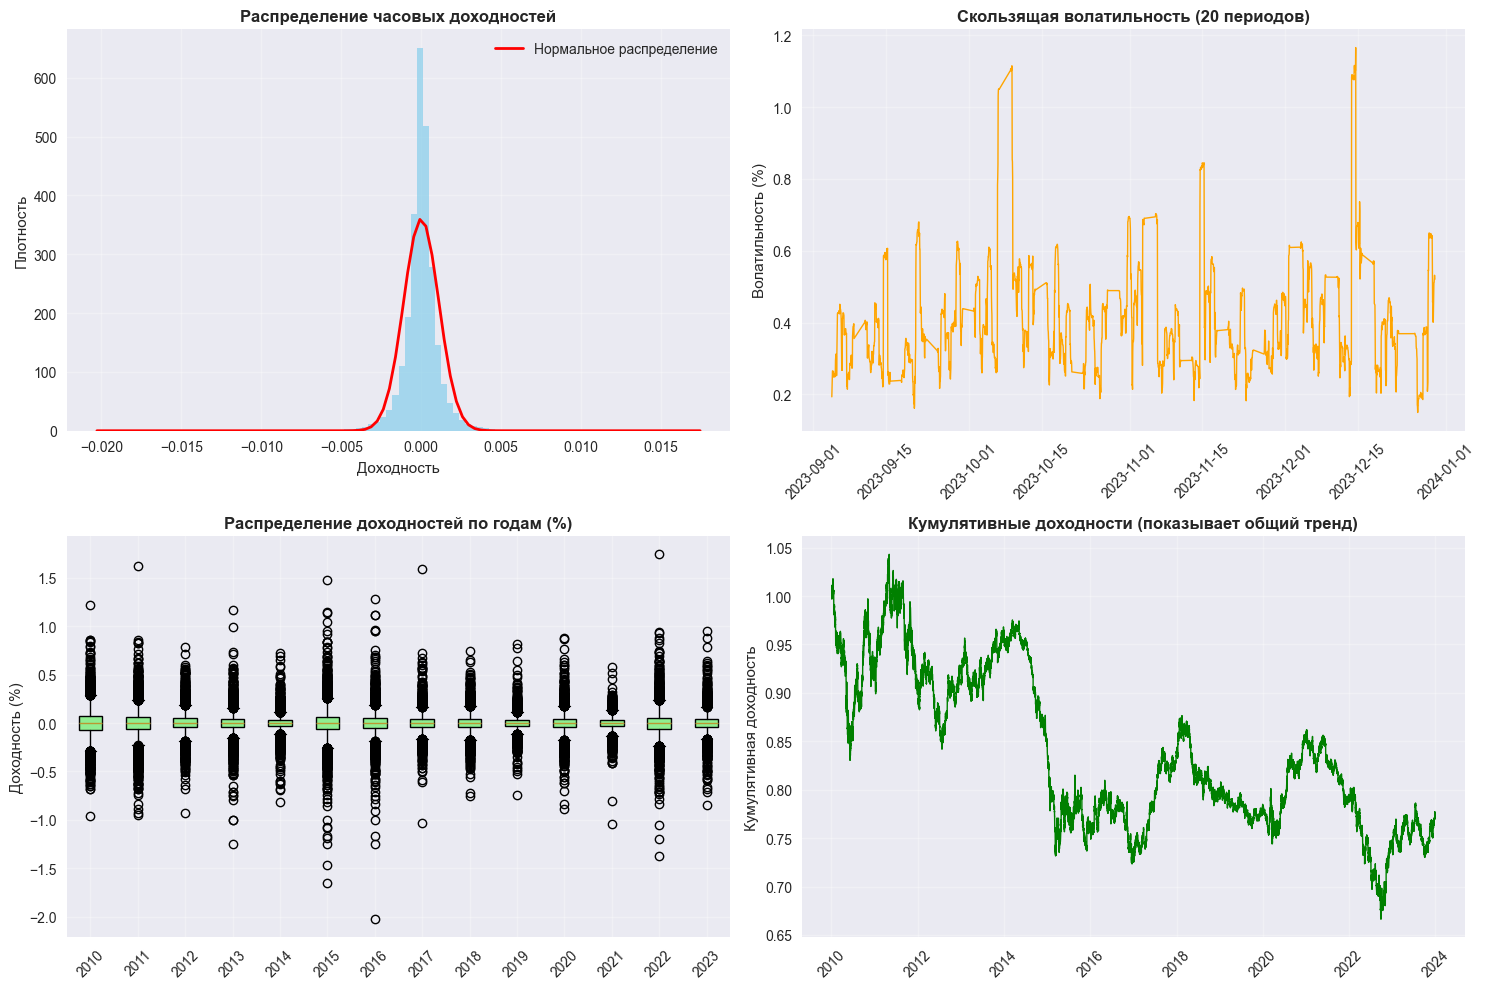


=== ПРОВЕРКА ПОВЕДЕНИЯ ДАННЫХ ===
Симметричность данных:
✓ Данные примерно симметричны (показатель: -0.018)

Тяжесть 'хвостов' (экстремальные события):
⚠️  Много экстремальных событий - рынок непредсказуем (показатель: 14.611)

=== ПРАКТИЧЕСКИЙ ВЫВОД ===
⚠️  Данные ведут себя НЕ как 'нормальные' - нужны специальные модели
    Стандартные статистические методы могут давать неточные результаты


In [11]:
# Визуализация доходностей (только самые информативные графики)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График 1: Гистограмма доходностей
returns_clean = df['returns'].dropna()
axes[0, 0].hist(returns_clean, bins=100, alpha=0.7, density=True, color='skyblue')
axes[0, 0].set_title('Распределение часовых доходностей', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Доходность')
axes[0, 0].set_ylabel('Плотность')
axes[0, 0].grid(True, alpha=0.3)

# Добавляем нормальное распределение для сравнения
x = np.linspace(returns_clean.min(), returns_clean.max(), 100)
normal_dist = stats.norm.pdf(x, returns_clean.mean(), returns_clean.std())
axes[0, 0].plot(x, normal_dist, 'r-', linewidth=2, label='Нормальное распределение')
axes[0, 0].legend()

# График 2: Скользящая волатильность
if 'volatility_20' in df.columns:
    # Показываем только последние 2000 точек для читаемости
    recent_data = df.tail(2000)
    axes[0, 1].plot(recent_data.index, recent_data['volatility_20'] * 100, linewidth=1, color='orange')
    axes[0, 1].set_title('Скользящая волатильность (20 периодов)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Волатильность (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)

# График 3: Box plot доходностей по годам
df_with_year = df.copy()
df_with_year['year'] = df_with_year.index.year
years = sorted(df_with_year['year'].unique())
yearly_returns = [df_with_year[df_with_year['year'] == year]['returns'].dropna() * 100 
                 for year in years]

# Берем каждый второй год для читаемости
step = max(1, len(years) // 10)
selected_years = years[::step]
selected_returns = [df_with_year[df_with_year['year'] == year]['returns'].dropna() * 100 
                   for year in selected_years]

bp = axes[1, 0].boxplot(selected_returns, labels=selected_years, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
axes[1, 0].set_title('Распределение доходностей по годам (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Доходность (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# График 4: Кумулятивные доходности (показываем общий тренд)
cumulative_returns = (1 + df['returns']).cumprod()
axes[1, 1].plot(cumulative_returns.index, cumulative_returns, linewidth=1, color='green')
axes[1, 1].set_title('Кумулятивные доходности (показывает общий тренд)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Кумулятивная доходность')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

# Сохраняем график в отчет
save_figure_to_report(report, 
                     title="Анализ доходностей и волатильности", 
                     caption="Визуализация распределения доходностей, волатильности и кумулятивных доходностей")

plt.show()

# Простая проверка "нормальности" данных
print("\n=== ПРОВЕРКА ПОВЕДЕНИЯ ДАННЫХ ===")

# Проверяем симметричность распределения
skewness = stats.skew(returns_clean)
kurtosis = stats.kurtosis(returns_clean, fisher=True)

print(f"Симметричность данных:")
if abs(skewness) < 0.5:
    print(f"✓ Данные примерно симметричны (показатель: {skewness:.3f})")
else:
    direction = "вправо" if skewness > 0 else "влево"
    print(f"⚠️  Данные смещены {direction} (показатель: {skewness:.3f})")

print(f"\nТяжесть 'хвостов' (экстремальные события):")
if kurtosis < 1:
    print(f"✓ Мало экстремальных событий (показатель: {kurtosis:.3f})")
elif kurtosis < 3:
    print(f"◐ Умеренное количество экстремальных событий (показатель: {kurtosis:.3f})")
else:
    print(f"⚠️  Много экстремальных событий - рынок непредсказуем (показатель: {kurtosis:.3f})")

# Практический вывод
print(f"\n=== ПРАКТИЧЕСКИЙ ВЫВОД ===")
if abs(skewness) > 0.5 or kurtosis > 3:
    print("⚠️  Данные ведут себя НЕ как 'нормальные' - нужны специальные модели")
    print("    Стандартные статистические методы могут давать неточные результаты")
else:
    print("✓ Данные ведут себя относительно 'нормально' - можно использовать стандартные методы")

# Сохраняем результаты анализа в отчет
report.add_header("2. Анализ волатильности и доходностей", level=2)

volatility_summary = f"""
**Основные показатели доходности:**
- Среднее изменение цены за час: {hourly_return_pct:.4f}%
- Среднее изменение цены за день: {daily_return_pct:.4f}%
- Среднее изменение цены за год: {annual_return_pct:.2f}%

**Показатели волатильности:**
- Часовая волатильность: {df['returns'].std() * 100:.4f}%
- Дневная волатильность: {df['returns'].std() * np.sqrt(24) * 100:.4f}%
- Годовая волатильность: {df['returns'].std() * np.sqrt(24 * 365) * 100:.2f}%

**Направление движения цен:**
- Часов с ростом цены: {positive_returns} ({positive_returns/len(df)*100:.1f}%)
- Часов с падением цены: {negative_returns} ({negative_returns/len(df)*100:.1f}%)
- Часов без изменений: {zero_returns} ({zero_returns/len(df)*100:.1f}%)

**Экстремальные движения:**
- Максимальный рост за час: {max_growth:.4f}% ({max_growth_date.strftime('%Y-%m-%d %H:%M')})
- Максимальное падение за час: {max_decline:.4f}% ({max_decline_date.strftime('%Y-%m-%d %H:%M')})

**Характеристики распределения:**
- Симметричность (skewness): {skewness:.3f}
- Эксцесс (kurtosis): {kurtosis:.3f}
- Характер рынка: {trend_assessment}, {vol_assessment.lower()}
"""

report.add_text(volatility_summary)


## 3. Корреляционный анализ и предсказуемость


=== ПРОВЕРКА ПРЕДСКАЗУЕМОСТИ ===
Влияние предыдущего часа на текущий: -0.0064
Влияние того же времени вчера: 0.0025

=== ЧТО ЭТО ОЗНАЧАЕТ ===
✓ Хорошо: движения цен слабо связаны с предыдущими - рынок эффективен
  Это означает, что сложно предсказать следующее движение по предыдущему
📅 Нет значимой суточной цикличности

=== КОРРЕЛЯЦИИ МЕЖДУ ЦЕНАМИ ===
Корреляционная матрица цен OHLC:
          open     high      low    close
open  1.000000 1.000000 1.000000 0.999900
high  1.000000 1.000000 0.999900 1.000000
low   1.000000 0.999900 1.000000 1.000000
close 0.999900 1.000000 1.000000 1.000000


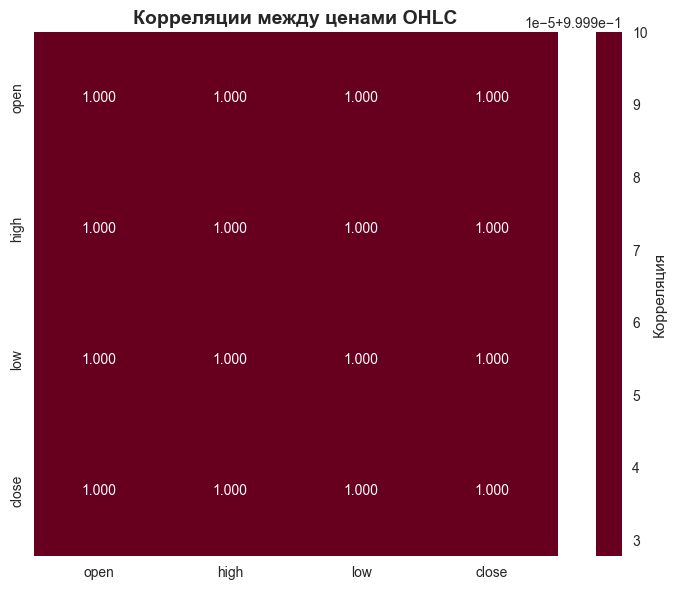

💡 Объяснение: Высокие корреляции (>0.95) между OHLC это нормально
   Это означает, что цены двигаются синхронно в течение часа


In [12]:
# Простая проверка предсказуемости
print("=== ПРОВЕРКА ПРЕДСКАЗУЕМОСТИ ===")

# Проверяем, влияет ли прошлое на будущее
autocorr_1h = df['returns'].autocorr(1)  # Связь с предыдущим часом
autocorr_24h = df['returns'].autocorr(24)  # Связь с тем же временем вчера

print(f"Влияние предыдущего часа на текущий: {autocorr_1h:.4f}")
print(f"Влияние того же времени вчера: {autocorr_24h:.4f}")

# Объяснение
print(f"\n=== ЧТО ЭТО ОЗНАЧАЕТ ===")
if abs(autocorr_1h) < 0.1:
    print("✓ Хорошо: движения цен слабо связаны с предыдущими - рынок эффективен")
    print("  Это означает, что сложно предсказать следующее движение по предыдущему")
else:
    print("⚠️  Внимание: есть связь с предыдущими движениями - возможны паттерны")
    print("  Это может дать возможности для краткосрочного прогнозирования")

if abs(autocorr_24h) > 0.05:
    print(f"📅 Есть суточная цикличность - движения в это время дня имеют тенденцию")
else:
    print(f"📅 Нет значимой суточной цикличности")

# Корреляционный анализ между ценовыми характеристиками
if len(price_cols) > 1:
    print(f"\n=== КОРРЕЛЯЦИИ МЕЖДУ ЦЕНАМИ ===")
    price_correlations = df[price_cols].corr()
    print("Корреляционная матрица цен OHLC:")
    print(price_correlations.round(4))
    
    # Визуализация корреляций
    plt.figure(figsize=(8, 6))
    sns.heatmap(price_correlations, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.3f', cbar_kws={'label': 'Корреляция'})
    plt.title('Корреляции между ценами OHLC', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Сохраняем график корреляции в отчет
    save_figure_to_report(report, 
                         title="Корреляционная матрица OHLC", 
                         caption="Корреляции между ценами открытия, максимума, минимума и закрытия")
    
    plt.show()
    
    print("💡 Объяснение: Высокие корреляции (>0.95) между OHLC это нормально")
    print("   Это означает, что цены двигаются синхронно в течение часа")
    
# Сохраняем результаты корреляционного анализа в отчет
report.add_header("3. Корреляционный анализ и предсказуемость", level=2)

correlation_summary = f"""
**Автокорреляционный анализ:**
- Влияние предыдущего часа на текущий: {autocorr_1h:.4f}
- Влияние того же времени вчера: {autocorr_24h:.4f}

**Интерпретация предсказуемости:**
- Связь с предыдущими движениями: {'Слабая (рынок эффективен)' if abs(autocorr_1h) < 0.1 else 'Умеренная (возможны паттерны)'}
- Суточная цикличность: {'Отсутствует' if abs(autocorr_24h) < 0.05 else 'Присутствует'}

**Корреляции между ценами OHLC:**
{f'- Средняя корреляция: {price_correlations.mean().mean():.4f}' if len(price_cols) > 1 else '- Анализ недоступен (недостаточно ценовых колонок)'}
"""

report.add_text(correlation_summary)


## 4. Анализ временных паттернов


=== АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ ===


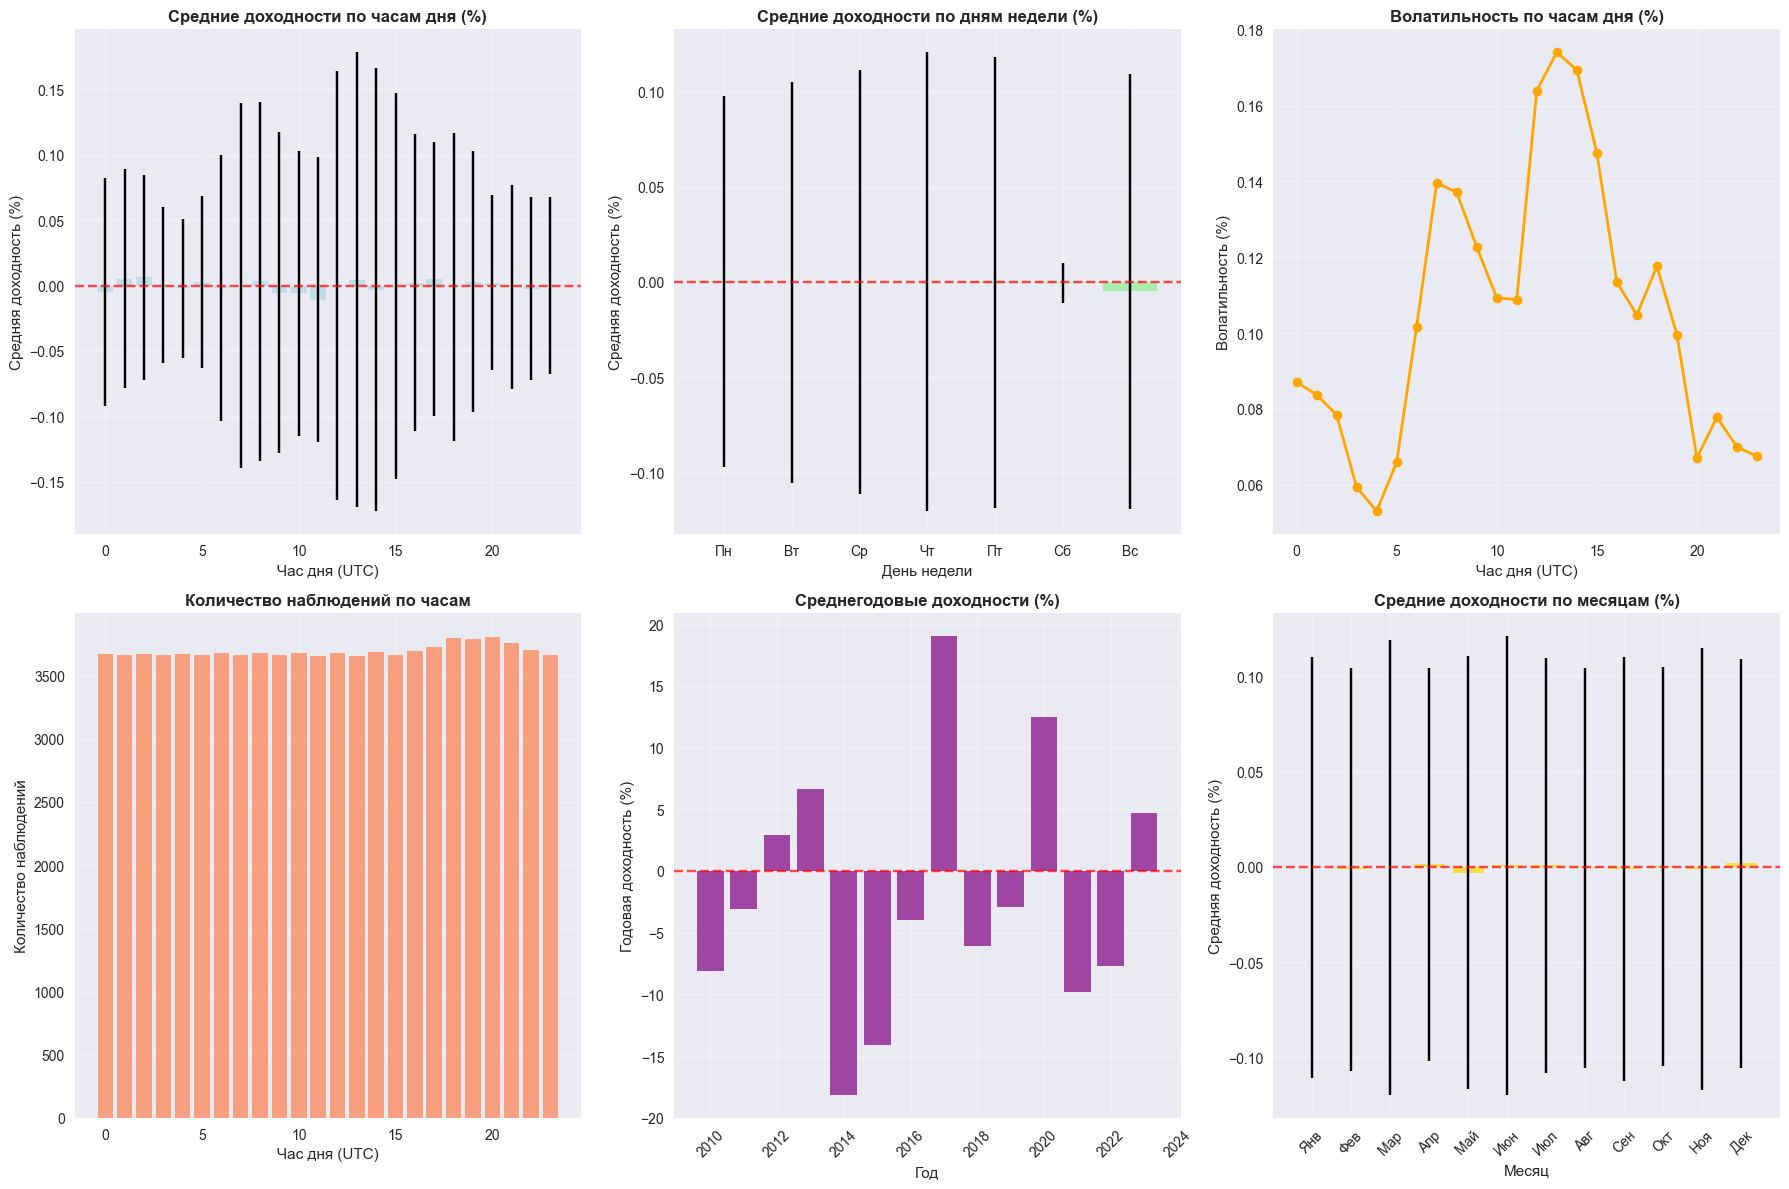

=== ПРАКТИЧЕСКИЕ ВЫВОДЫ ===
📈 АКТИВНОСТЬ ПО ЧАСАМ (UTC):
Самые волатильные часы:
  13:00 UTC - 0.1741%
  14:00 UTC - 0.1694%
  12:00 UTC - 0.1639%
  15:00 UTC - 0.1476%
   7:00 UTC - 0.1396%
Самые спокойные часы:
   4:00 UTC - 0.0530%
   3:00 UTC - 0.0595%
   5:00 UTC - 0.0660%
  20:00 UTC - 0.0671%
  23:00 UTC - 0.0675%

📅 АКТИВНОСТЬ ПО ДНЯМ НЕДЕЛИ:
Волатильность в выходные: 0.1062%
Волатильность в рабочие дни: 0.1109%
✓ Выходные спокойнее рабочих дней - обычное поведение форекс

📊 ПРОИЗВОДИТЕЛЬНОСТЬ ПО ГОДАМ:
Лучший год: 2017 (19.04%)
Худший год: 2014 (-18.15%)


In [13]:
# Создание временных признаков
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # 0 = понедельник
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['is_weekend'] = df['day_of_week'].isin([5, 6])  # суббота, воскресенье

# Названия дней недели и месяцев для графиков
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
               'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

print("=== АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ ===")

# Информативные графики с правильным масштабом
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Средние доходности по часам (в процентах для лучшего восприятия)
hourly_returns = df.groupby('hour')['returns'].mean() * 100  # конвертируем в проценты
hourly_std = df.groupby('hour')['returns'].std() * 100

axes[0, 0].bar(hourly_returns.index, hourly_returns.values, 
               yerr=hourly_std.values, alpha=0.7, capsize=3, color='lightblue')
axes[0, 0].set_title('Средние доходности по часам дня (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Час дня (UTC)')
axes[0, 0].set_ylabel('Средняя доходность (%)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 2. Средние доходности по дням недели (в процентах)
daily_returns = df.groupby('day_of_week')['returns'].mean() * 100
daily_std = df.groupby('day_of_week')['returns'].std() * 100

axes[0, 1].bar(range(7), daily_returns.values, 
               yerr=daily_std.values, alpha=0.7, capsize=3, color='lightgreen')
axes[0, 1].set_title('Средние доходности по дням недели (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('День недели')
axes[0, 1].set_ylabel('Средняя доходность (%)')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 3. Волатильность по часам (в процентах)
hourly_vol = df.groupby('hour')['returns'].std() * 100
axes[0, 2].plot(hourly_vol.index, hourly_vol.values, marker='o', linewidth=2, color='orange')
axes[0, 2].set_title('Волатильность по часам дня (%)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Час дня (UTC)')
axes[0, 2].set_ylabel('Волатильность (%)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Количество наблюдений по часам (проверяем равномерность данных)
hourly_count = df.groupby('hour').size()
axes[1, 0].bar(hourly_count.index, hourly_count.values, alpha=0.7, color='coral')
axes[1, 0].set_title('Количество наблюдений по часам', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Час дня (UTC)')
axes[1, 0].set_ylabel('Количество наблюдений')
axes[1, 0].grid(True, alpha=0.3)

# 5. Среднегодовые доходности
yearly_returns = df.groupby('year')['returns'].mean() * 100 * 365 * 24  # Годовая доходность
years = yearly_returns.index
axes[1, 1].bar(years, yearly_returns.values, alpha=0.7, color='purple')
axes[1, 1].set_title('Среднегодовые доходности (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Год')
axes[1, 1].set_ylabel('Годовая доходность (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 6. Сезонность по месяцам
monthly_returns = df.groupby('month')['returns'].mean() * 100
monthly_std = df.groupby('month')['returns'].std() * 100
axes[1, 2].bar(range(1, 13), monthly_returns.values, 
               yerr=monthly_std.values, alpha=0.7, capsize=3, color='gold')
axes[1, 2].set_title('Средние доходности по месяцам (%)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Месяц')
axes[1, 2].set_ylabel('Средняя доходность (%)')
axes[1, 2].set_xticks(range(1, 13))
axes[1, 2].set_xticklabels([m[:3] for m in month_names], rotation=45)
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()

# Сохраняем график временных паттернов в отчет
save_figure_to_report(report, 
                     title="Анализ временных паттернов", 
                     caption="Доходности и волатильность по часам, дням недели, месяцам и годам")

plt.show()

# Практический анализ паттернов
print("=== ПРАКТИЧЕСКИЕ ВЫВОДЫ ===")

# Анализ торговых сессий
print("📈 АКТИВНОСТЬ ПО ЧАСАМ (UTC):")
top_volatile_hours = hourly_vol.nlargest(5)
print("Самые волатильные часы:")
for hour, vol in top_volatile_hours.items():
    print(f"  {hour:2d}:00 UTC - {vol:.4f}%")

low_volatile_hours = hourly_vol.nsmallest(5)
print("Самые спокойные часы:")
for hour, vol in low_volatile_hours.items():
    print(f"  {hour:2d}:00 UTC - {vol:.4f}%")

# Анализ дней недели
print(f"\n📅 АКТИВНОСТЬ ПО ДНЯМ НЕДЕЛИ:")
weekend_vol = df[df['is_weekend']]['returns'].std() * 100
weekday_vol = df[~df['is_weekend']]['returns'].std() * 100
print(f"Волатильность в выходные: {weekend_vol:.4f}%")
print(f"Волатильность в рабочие дни: {weekday_vol:.4f}%")

if weekend_vol < weekday_vol:
    print("✓ Выходные спокойнее рабочих дней - обычное поведение форекс")
else:
    print("⚠️ Выходные более волатильны - нестандартное поведение")

# Лучшие/худшие года
best_year = yearly_returns.idxmax()
worst_year = yearly_returns.idxmin()
print(f"\n📊 ПРОИЗВОДИТЕЛЬНОСТЬ ПО ГОДАМ:")
print(f"Лучший год: {best_year} ({yearly_returns[best_year]:.2f}%)")
print(f"Худший год: {worst_year} ({yearly_returns[worst_year]:.2f}%)")

# Сохраняем результаты временного анализа в отчет
report.add_header("4. Анализ временных паттернов", level=2)

# Топ волатильных часов
top_volatile_text = "**Самые волатильные часы (UTC):**\n"
for hour, vol in top_volatile_hours.items():
    top_volatile_text += f"- {hour:2d}:00 UTC - {vol:.4f}%\n"

low_volatile_text = "\n**Самые спокойные часы (UTC):**\n"
for hour, vol in low_volatile_hours.items():
    low_volatile_text += f"- {hour:2d}:00 UTC - {vol:.4f}%\n"

temporal_summary = f"""
{top_volatile_text}
{low_volatile_text}

**Анализ активности по дням недели:**
- Волатильность в выходные: {weekend_vol:.4f}%
- Волатильность в рабочие дни: {weekday_vol:.4f}%
- Характер: {'Выходные спокойнее (норма для форекс)' if weekend_vol < weekday_vol else 'Выходные более волатильны (нестандартно)'}

**Производительность по годам:**
- Лучший год: {best_year} ({yearly_returns[best_year]:.2f}%)
- Худший год: {worst_year} ({yearly_returns[worst_year]:.2f}%)
"""

report.add_text(temporal_summary)


In [14]:
# Статистические тесты временных паттернов с объяснениями
print("=== СТАТИСТИЧЕСКАЯ ПРОВЕРКА ПАТТЕРНОВ ===")
print("💡 Эти тесты проверяют, есть ли РЕАЛЬНЫЕ различия между группами, или это случайность")

# ANOVA тест - проверяет различия между группами
from scipy.stats import f_oneway

# Что такое ANOVA:
print("\n🔬 ANOVA тест:")
print("   Проверяет: 'Действительно ли разные часы/дни имеют разную доходность?'")
print("   p-value < 0.05 = Да, различия значимы (не случайны)")
print("   p-value > 0.05 = Нет, различия могут быть случайными")

# Тест по часам
hourly_groups = [df[df['hour'] == h]['returns'].dropna() for h in range(24)]
f_stat_hour, p_val_hour = f_oneway(*hourly_groups)
print(f"\n📊 ANOVA по часам:")
print(f"   p-value: {p_val_hour:.6f}")
if p_val_hour < 0.05:
    print(f"   ✅ Результат: Часы дня ЗНАЧИМО влияют на доходность")
    print(f"   📈 Практически: Можно использовать время дня для стратегий")
else:
    print(f"   ❌ Результат: Влияние часов может быть случайным")
    print(f"   📈 Практически: Время дня не дает преимущества")

# Тест по дням недели
daily_groups = [df[df['day_of_week'] == d]['returns'].dropna() for d in range(7)]
f_stat_day, p_val_day = f_oneway(*daily_groups)
print(f"\n📅 ANOVA по дням недели:")
print(f"   p-value: {p_val_day:.6f}")
if p_val_day < 0.05:
    print(f"   ✅ Результат: Дни недели ЗНАЧИМО влияют на доходность")
    print(f"   📈 Практически: Есть 'понедельничий эффект' или похожие паттерны")
else:
    print(f"   ❌ Результат: Различия между днями могут быть случайными")
    print(f"   📈 Практически: День недели не дает торгового преимущества")

# Тест по месяцам
monthly_groups = [df[df['month'] == m]['returns'].dropna() for m in range(1, 13)]
f_stat_month, p_val_month = f_oneway(*monthly_groups)
print(f"\n📆 ANOVA по месяцам:")
print(f"   p-value: {p_val_month:.6f}")
if p_val_month < 0.05:
    print(f"   ✅ Результат: Месяцы ЗНАЧИМО влияют на доходность")
    print(f"   📈 Практически: Есть сезонные эффекты")
else:
    print(f"   ❌ Результат: Сезонные различия могут быть случайными")
    print(f"   📈 Практически: Сезонность не дает торгового преимущества")

# Сравнение выходных и рабочих дней
weekend_returns = df[df['is_weekend']]['returns'].dropna()
weekday_returns = df[~df['is_weekend']]['returns'].dropna()

from scipy.stats import ttest_ind

print(f"\n🔬 T-тест (выходные vs рабочие дни):")
print("   Проверяет: 'Есть ли разница между выходными и рабочими днями?'")

t_stat, p_val_weekend = ttest_ind(weekend_returns, weekday_returns)
print(f"   p-value: {p_val_weekend:.6f}")

if p_val_weekend < 0.05:
    print(f"   ✅ Результат: Выходные и рабочие дни ЗНАЧИМО отличаются")
    weekend_mean = weekend_returns.mean() * 100
    weekday_mean = weekday_returns.mean() * 100
    if weekend_mean > weekday_mean:
        print(f"   📈 Практически: Выходные более прибыльны ({weekend_mean:.4f}% vs {weekday_mean:.4f}%)")
    else:
        print(f"   📈 Практически: Рабочие дни более прибыльны ({weekday_mean:.4f}% vs {weekend_mean:.4f}%)")
else:
    print(f"   ❌ Результат: Различия между выходными и рабочими днями незначимы")
    print(f"   📈 Практически: Тип дня (выходной/рабочий) не влияет на доходность")

print(f"\n🎯 ОБЩИЙ ПРАКТИЧЕСКИЙ ВЫВОД:")
significant_patterns = []
if p_val_hour < 0.05:
    significant_patterns.append("время дня")
if p_val_day < 0.05:
    significant_patterns.append("день недели")
if p_val_month < 0.05:
    significant_patterns.append("месяц")
if p_val_weekend < 0.05:
    significant_patterns.append("тип дня (выходной/рабочий)")

if significant_patterns:
    print(f"✅ Найдены значимые паттерны: {', '.join(significant_patterns)}")
    print(f"📈 Эти факторы можно использовать при построении торговых стратегий")
else:
    print(f"❌ Значимых временных паттернов не обнаружено")
    print(f"📈 Время не дает существенного преимущества для торговли")

# Сохраняем результаты статистических тестов в отчет
statistical_tests_summary = f"""
**Результаты статистических тестов (ANOVA и t-тесты):**

**ANOVA тест по часам дня:**
- p-value: {p_val_hour:.6f}
- Результат: {'Часы дня ЗНАЧИМО влияют на доходность' if p_val_hour < 0.05 else 'Влияние часов может быть случайным'}

**ANOVA тест по дням недели:**
- p-value: {p_val_day:.6f}
- Результат: {'Дни недели ЗНАЧИМО влияют на доходность' if p_val_day < 0.05 else 'Различия между днями могут быть случайными'}

**ANOVA тест по месяцам:**
- p-value: {p_val_month:.6f}
- Результат: {'Месяцы ЗНАЧИМО влияют на доходность' if p_val_month < 0.05 else 'Сезонные различия могут быть случайными'}

**T-тест (выходные vs рабочие дни):**
- p-value: {p_val_weekend:.6f}
- Результат: {'Выходные и рабочие дни ЗНАЧИМО отличаются' if p_val_weekend < 0.05 else 'Различия между типами дней незначимы'}

**Найденные значимые паттерны:**
{', '.join(significant_patterns) if significant_patterns else 'Значимых паттернов не найдено'}

**Практический вывод:**
{'Эти факторы можно использовать при построении торговых стратегий' if significant_patterns else 'Время не дает существенного преимущества для торговли'}
"""

report.add_text(statistical_tests_summary)


=== СТАТИСТИЧЕСКАЯ ПРОВЕРКА ПАТТЕРНОВ ===
💡 Эти тесты проверяют, есть ли РЕАЛЬНЫЕ различия между группами, или это случайность

🔬 ANOVA тест:
   Проверяет: 'Действительно ли разные часы/дни имеют разную доходность?'
   p-value < 0.05 = Да, различия значимы (не случайны)
   p-value > 0.05 = Нет, различия могут быть случайными

📊 ANOVA по часам:
   p-value: 0.000000
   ✅ Результат: Часы дня ЗНАЧИМО влияют на доходность
   📈 Практически: Можно использовать время дня для стратегий

📅 ANOVA по дням недели:
   p-value: 0.445925
   ❌ Результат: Различия между днями могут быть случайными
   📈 Практически: День недели не дает торгового преимущества

📆 ANOVA по месяцам:
   p-value: 0.357828
   ❌ Результат: Сезонные различия могут быть случайными
   📈 Практически: Сезонность не дает торгового преимущества

🔬 T-тест (выходные vs рабочие дни):
   Проверяет: 'Есть ли разница между выходными и рабочими днями?'
   p-value: 0.029425
   ✅ Результат: Выходные и рабочие дни ЗНАЧИМО отличаются
   📈 Практич

## 5. Анализ аномалий и выбросов


=== ПОИСК АНОМАЛЬНЫХ ДВИЖЕНИЙ ЦЕН ===
💡 Выбросы = экстремально большие движения цен, которые сильно отличаются от обычных
🔍 IQR метод:
   Нормальный диапазон: от -0.001767 до 0.001769
   Все что выходит за эти границы = выброс

=== РЕЗУЛЬТАТЫ ПОИСКА ВЫБРОСОВ ===
Общее количество наблюдений: 88,629
Количество выбросов: 7,487 (8.45%)

Положительные выбросы (резкий рост): 3720
Отрицательные выбросы (резкое падение): 3767

🔺 ТОП-5 САМЫХ БОЛЬШИХ РОСТОВ:
1. 2022-11-10 13:00: +1.7439%
2. 2011-11-30 13:00: +1.6257%
3. 2017-04-23 21:00: +1.5960%
4. 2015-12-03 13:00: +1.4766%
5. 2016-06-03 12:00: +1.2832%

🔻 ТОП-5 САМЫХ БОЛЬШИХ ПАДЕНИЙ:
1. 2016-06-24 02:00: -2.0280%
2. 2015-06-28 21:00: -1.6504%
3. 2015-10-28 18:00: -1.4724%
4. 2022-09-13 12:00: -1.3737%
5. 2015-11-06 13:00: -1.2529%


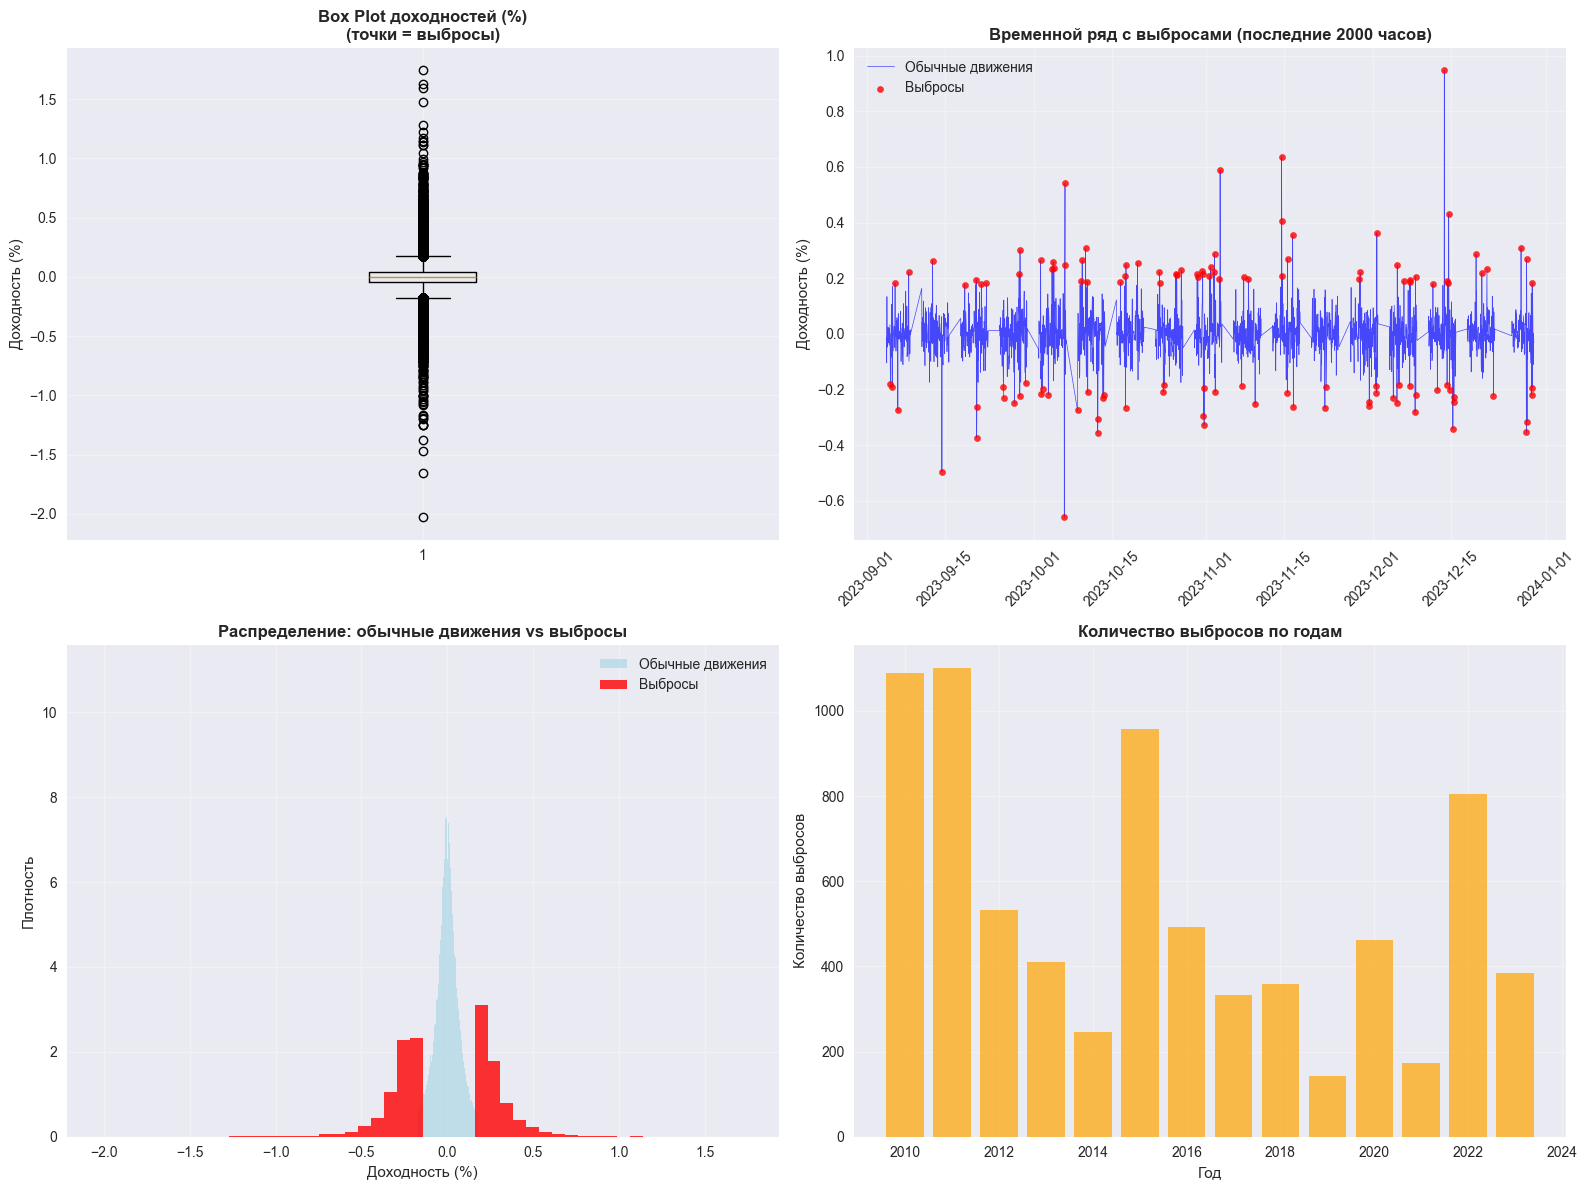


=== АНАЛИЗ КЛАСТЕРИЗАЦИИ ЭКСТРЕМАЛЬНЫХ СОБЫТИЙ ===
💡 Проверяем, идут ли экстремальные события группами или по отдельности

📅 РАСПРЕДЕЛЕНИЕ ПО ДНЯМ:
Дни без экстремальных событий: 2,303
Дни с 1 экстремальным событием: 973
Дни с 2+ экстремальными событиями: 1,832

⚠️  КЛАСТЕРИЗАЦИЯ ОБНАРУЖЕНА!
   1832 дней с множественными экстремальными событиями
   Это означает, что волатильность идет 'волнами'

🔥 Самые волатильные дни:
   2020-03-18: 14 экстремальных событий
   2010-05-20: 13 экстремальных событий
   2010-06-10: 13 экстремальных событий
   2016-06-24: 13 экстремальных событий
   2010-05-06: 12 экстремальных событий

🎯 ПРАКТИЧЕСКИЕ ВЫВОДЫ ДЛЯ РИСК-МЕНЕДЖМЕНТА:
⚠️  Высокий процент выбросов (8.4%)
   Рынок непредсказуем, нужны консервативные стоп-лоссы

📊 МАКСИМАЛЬНЫЕ ДВИЖЕНИЯ ЗА ЧАС:
Максимальная потеря: 2.028%
Максимальная прибыль: 1.744%
💡 Рекомендуемый размер позиции: не более 49.3% от капитала


In [15]:
# Анализ выбросов с понятными объяснениями
print("=== ПОИСК АНОМАЛЬНЫХ ДВИЖЕНИЙ ЦЕН ===")
print("💡 Выбросы = экстремально большие движения цен, которые сильно отличаются от обычных")

def detect_outliers_simple(data, method='iqr'):
    """Простая детекция выбросов с объяснениями"""
    
    if method == 'iqr':
        # IQR метод: основан на "коробке" в box plot
        Q1 = data.quantile(0.25)  # 25% квантиль
        Q3 = data.quantile(0.75)  # 75% квантиль
        IQR = Q3 - Q1  # Размер "коробки"
        
        # Все что выходит за 1.5 * IQR от коробки = выброс
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (data < lower_bound) | (data > upper_bound)
        
        print(f"🔍 IQR метод:")
        print(f"   Нормальный диапазон: от {lower_bound:.6f} до {upper_bound:.6f}")
        print(f"   Все что выходит за эти границы = выброс")
        
        return outliers, lower_bound, upper_bound

# Детекция выбросов
returns_clean = df['returns'].dropna()
outliers_iqr, lower_bound, upper_bound = detect_outliers_simple(returns_clean, method='iqr')

print(f"\n=== РЕЗУЛЬТАТЫ ПОИСКА ВЫБРОСОВ ===")
print(f"Общее количество наблюдений: {len(returns_clean):,}")
print(f"Количество выбросов: {outliers_iqr.sum():,} ({outliers_iqr.sum()/len(returns_clean)*100:.2f}%)")

# Разделяем на положительные и отрицательные выбросы
positive_outliers = returns_clean[(returns_clean > upper_bound)]
negative_outliers = returns_clean[(returns_clean < lower_bound)]

print(f"\nПоложительные выбросы (резкий рост): {len(positive_outliers)}")
print(f"Отрицательные выбросы (резкое падение): {len(negative_outliers)}")

# Топ экстремальных событий
print(f"\n🔺 ТОП-5 САМЫХ БОЛЬШИХ РОСТОВ:")
if len(positive_outliers) > 0:
    top_gains = positive_outliers.nlargest(5)
    for i, (date, ret) in enumerate(top_gains.items(), 1):
        print(f"{i}. {date.strftime('%Y-%m-%d %H:%M')}: +{ret*100:.4f}%")
else:
    print("   Больших ростов не найдено")

print(f"\n🔻 ТОП-5 САМЫХ БОЛЬШИХ ПАДЕНИЙ:")
if len(negative_outliers) > 0:
    top_losses = negative_outliers.nsmallest(5)
    for i, (date, ret) in enumerate(top_losses.items(), 1):
        print(f"{i}. {date.strftime('%Y-%m-%d %H:%M')}: {ret*100:.4f}%")
else:
    print("   Больших падений не найдено")

# Визуализация выбросов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Box plot с выбросами
axes[0, 0].boxplot(returns_clean * 100, vert=True)
axes[0, 0].set_title('Box Plot доходностей (%)\n(точки = выбросы)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Доходность (%)')
axes[0, 0].grid(True, alpha=0.3)

# График 2: Временной ряд с выделенными выбросами
sample_returns = returns_clean.tail(2000)  # Последние 2000 точек
sample_outliers = outliers_iqr.reindex(sample_returns.index, fill_value=False)

axes[0, 1].plot(sample_returns.index, sample_returns * 100, 
                linewidth=0.5, alpha=0.7, label='Обычные движения', color='blue')

outlier_dates = sample_returns.index[sample_outliers]
if len(outlier_dates) > 0:
    outlier_values = sample_returns.loc[outlier_dates] * 100
    axes[0, 1].scatter(outlier_dates, outlier_values, color='red', s=20, 
                      alpha=0.8, label='Выбросы', zorder=5)

axes[0, 1].set_title('Временной ряд с выбросами (последние 2000 часов)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Доходность (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# График 3: Гистограмма нормальных vs выбросов
normal_returns = returns_clean[~outliers_iqr] * 100
outlier_returns = returns_clean[outliers_iqr] * 100

axes[1, 0].hist(normal_returns, bins=100, alpha=0.7, density=True, 
                label='Обычные движения', color='lightblue')
if len(outlier_returns) > 0:
    axes[1, 0].hist(outlier_returns, bins=50, alpha=0.8, density=True, 
                    color='red', label='Выбросы')
axes[1, 0].set_title('Распределение: обычные движения vs выбросы', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Доходность (%)')
axes[1, 0].set_ylabel('Плотность')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# График 4: Выбросы по годам
if outliers_iqr.sum() > 0:
    # Используем returns_clean с выбросами, а не df
    outlier_data = returns_clean[outliers_iqr]
    outliers_by_year = outlier_data.groupby(outlier_data.index.year).size()
    axes[1, 1].bar(outliers_by_year.index, outliers_by_year.values, alpha=0.7, color='orange')
    axes[1, 1].set_title('Количество выбросов по годам', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Год')
    axes[1, 1].set_ylabel('Количество выбросов')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Выбросов не найдено', 
                   transform=axes[1, 1].transAxes, ha='center', va='center',
                   fontsize=14)
    axes[1, 1].set_title('Количество выбросов по годам', fontsize=12, fontweight='bold')

plt.tight_layout()

# Сохраняем график анализа аномалий в отчет
save_figure_to_report(report, 
                     title="Анализ аномалий и выбросов", 
                     caption="Визуализация выбросов: box plot, временной ряд, распределения и динамика по годам")

plt.show()

# Анализ кластеризации экстремальных событий
if outliers_iqr.sum() > 0:
    print("\n=== АНАЛИЗ КЛАСТЕРИЗАЦИИ ЭКСТРЕМАЛЬНЫХ СОБЫТИЙ ===")
    print("💡 Проверяем, идут ли экстремальные события группами или по отдельности")
    
    # Создаем Series с выбросами для корректного resampling
    outlier_events = returns_clean[outliers_iqr]
    daily_outliers = outlier_events.resample('1D').count()
    
    days_with_no_outliers = (daily_outliers == 0).sum()
    days_with_one_outlier = (daily_outliers == 1).sum()
    days_with_multiple_outliers = (daily_outliers >= 2).sum()
    
    print(f"\n📅 РАСПРЕДЕЛЕНИЕ ПО ДНЯМ:")
    print(f"Дни без экстремальных событий: {days_with_no_outliers:,}")
    print(f"Дни с 1 экстремальным событием: {days_with_one_outlier:,}")
    print(f"Дни с 2+ экстремальными событиями: {days_with_multiple_outliers:,}")
    
    if days_with_multiple_outliers > 0:
        print(f"\n⚠️  КЛАСТЕРИЗАЦИЯ ОБНАРУЖЕНА!")
        print(f"   {days_with_multiple_outliers} дней с множественными экстремальными событиями")
        print(f"   Это означает, что волатильность идет 'волнами'")
        
        top_volatile_days = daily_outliers[daily_outliers >= 2].nlargest(5)
        if len(top_volatile_days) > 0:
            print(f"\n🔥 Самые волатильные дни:")
            for date, count in top_volatile_days.items():
                print(f"   {date.strftime('%Y-%m-%d')}: {count} экстремальных событий")
    else:
        print(f"\n✓ Экстремальные события происходят изолированно")
        print(f"   Нет выраженной кластеризации волатильности")
else:
    print("\n=== АНАЛИЗ КЛАСТЕРИЗАЦИИ ===")
    print("✓ Выбросов не обнаружено - анализ кластеризации не требуется")

print(f"\n🎯 ПРАКТИЧЕСКИЕ ВЫВОДЫ ДЛЯ РИСК-МЕНЕДЖМЕНТА:")
if outliers_iqr.sum() > 0:
    outlier_percentage = outliers_iqr.sum() / len(returns_clean)
    if outlier_percentage > 0.05:
        print(f"⚠️  Высокий процент выбросов ({outlier_percentage*100:.1f}%)")
        print(f"   Рынок непредсказуем, нужны консервативные стоп-лоссы")
    else:
        print(f"✓ Умеренный процент выбросов ({outlier_percentage*100:.1f}%)")
        print(f"   Рынок относительно предсказуем")
    
    max_loss_pct = abs(returns_clean.min()) * 100
    max_gain_pct = returns_clean.max() * 100
    print(f"\n📊 МАКСИМАЛЬНЫЕ ДВИЖЕНИЯ ЗА ЧАС:")
    print(f"Максимальная потеря: {max_loss_pct:.3f}%")
    print(f"Максимальная прибыль: {max_gain_pct:.3f}%")
    if max_loss_pct > 0:
        print(f"💡 Рекомендуемый размер позиции: не более {100/max_loss_pct:.1f}% от капитала")
else:
    print("✓ Выбросов не обнаружено - рынок стабилен")
    print("📊 Можно использовать стандартные методы риск-менеджмента")

# Сохраняем результаты анализа аномалий в отчет
report.add_header("5. Анализ аномалий и выбросов", level=2)

# Формируем списки топ событий
top_gains_text = ""
if len(positive_outliers) > 0:
    top_gains = positive_outliers.nlargest(5)
    for i, (date, ret) in enumerate(top_gains.items(), 1):
        top_gains_text += f"{i}. {date.strftime('%Y-%m-%d %H:%M')}: +{ret*100:.4f}%\n"
else:
    top_gains_text = "Больших ростов не найдено\n"

top_losses_text = ""
if len(negative_outliers) > 0:
    top_losses = negative_outliers.nsmallest(5)
    for i, (date, ret) in enumerate(top_losses.items(), 1):
        top_losses_text += f"{i}. {date.strftime('%Y-%m-%d %H:%M')}: {ret*100:.4f}%\n"
else:
    top_losses_text = "Больших падений не найдено\n"

outliers_summary = f"""
**Статистика выбросов (IQR метод):**
- Общее количество наблюдений: {len(returns_clean):,}
- Количество выбросов: {outliers_iqr.sum():,} ({outliers_iqr.sum()/len(returns_clean)*100:.2f}%)
- Положительные выбросы (резкий рост): {len(positive_outliers)}
- Отрицательные выбросы (резкое падение): {len(negative_outliers)}

**ТОП-5 самых больших ростов:**
{top_gains_text}

**ТОП-5 самых больших падений:**
{top_losses_text}
"""

if outliers_iqr.sum() > 0:
    outlier_percentage = outliers_iqr.sum() / len(returns_clean)
    max_loss_pct = abs(returns_clean.min()) * 100
    max_gain_pct = returns_clean.max() * 100
    
    risk_assessment = f"""
**Анализ кластеризации:**
- Дни без экстремальных событий: {days_with_no_outliers:,}
- Дни с 1 экстремальным событием: {days_with_one_outlier:,}
- Дни с 2+ экстремальными событиями: {days_with_multiple_outliers:,}
- Кластеризация: {'Обнаружена' if days_with_multiple_outliers > 0 else 'Отсутствует'}

**Риск-менеджмент:**
- Максимальная потеря за час: {max_loss_pct:.3f}%
- Максимальная прибыль за час: {max_gain_pct:.3f}%
- Рекомендуемый размер позиции: не более {100/max_loss_pct:.1f}% от капитала
- Оценка рынка: {'Высокий риск (>5% выбросов)' if outlier_percentage > 0.05 else 'Умеренный риск'}
"""
    outliers_summary += risk_assessment

report.add_text(outliers_summary)


## 6. Анализ объёмов и дополнительных характеристик


=== АНАЛИЗ ТОРГОВЫХ ОБЪЁМОВ И СПРЕДОВ ===
✅ Найдены данные об объёмах: volume

📊 СТАТИСТИКА ОБЪЁМОВ:
Средний объём: 2575
Медианный объём: 1653
Максимальный объём: 53617

🔗 Связь объёма с размером движений цен: 0.4252
✅ Высокие объёмы связаны с большими движениями - хороший сигнал


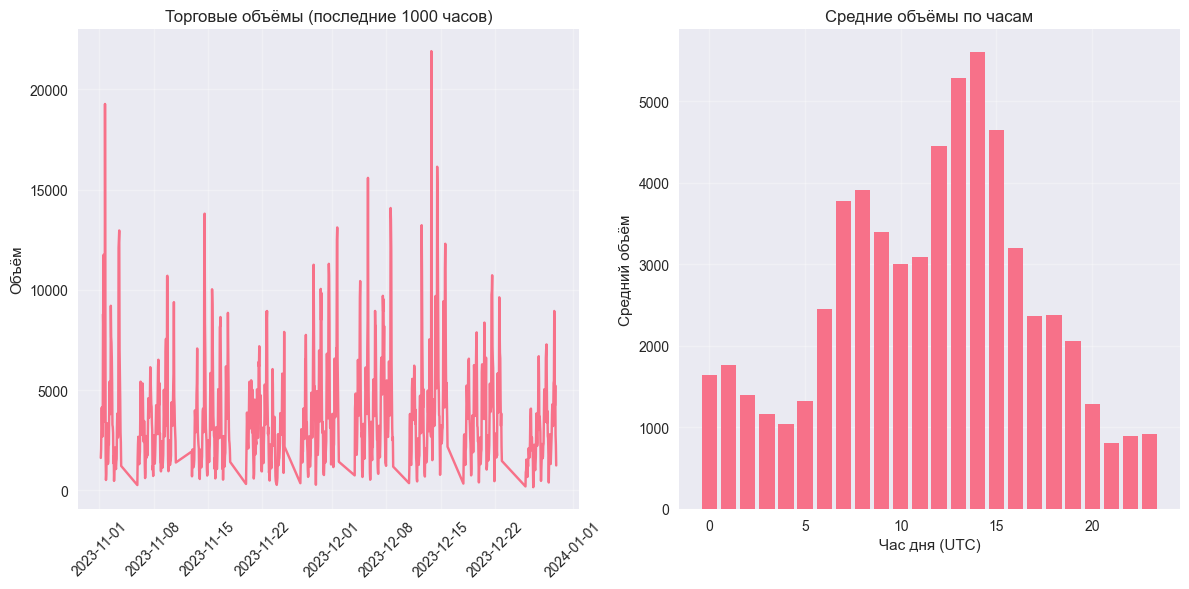


✅ Анализ объёмов/активности завершен!


In [16]:
# Анализ объёмов и дополнительных характеристик
print("=== АНАЛИЗ ТОРГОВЫХ ОБЪЁМОВ И СПРЕДОВ ===")

# Проверяем наличие данных об объёмах
if volume_cols:
    volume_col = volume_cols[0]
    print(f"✅ Найдены данные об объёмах: {volume_col}")
    
    # Базовая статистика объёмов
    print(f"\n📊 СТАТИСТИКА ОБЪЁМОВ:")
    print(f"Средний объём: {df[volume_col].mean():.0f}")
    print(f"Медианный объём: {df[volume_col].median():.0f}")
    print(f"Максимальный объём: {df[volume_col].max():.0f}")
    
    # Корреляция с движениями цен
    volume_return_corr = df[volume_col].corr(df['returns'].abs())
    print(f"\n🔗 Связь объёма с размером движений цен: {volume_return_corr:.4f}")
    
    if volume_return_corr > 0.1:
        print("✅ Высокие объёмы связаны с большими движениями - хороший сигнал")
    else:
        print("⚠️ Слабая связь объёма с движениями цен")
        
    # График объёмов
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    recent_data = df.tail(1000)
    plt.plot(recent_data.index, recent_data[volume_col])
    plt.title('Торговые объёмы (последние 1000 часов)')
    plt.ylabel('Объём')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    hourly_volume = df.groupby('hour')[volume_col].mean()
    plt.bar(hourly_volume.index, hourly_volume.values)
    plt.title('Средние объёмы по часам')
    plt.xlabel('Час дня (UTC)')
    plt.ylabel('Средний объём')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Сохраняем график объемов в отчет
    save_figure_to_report(report, 
                         title="Анализ торговых объемов", 
                         caption="Динамика объемов и их распределение по часам дня")
    
    plt.show()
    
else:
    print("❌ Данные об объёмах не найдены")
    
    # Альтернативный анализ через спреды High-Low
    high_col = next((col for col in df.columns if 'high' in col.lower()), None)
    low_col = next((col for col in df.columns if 'low' in col.lower()), None)
    
    if high_col and low_col:
        print(f"\n📊 АЛЬТЕРНАТИВНЫЙ АНАЛИЗ: СПРЕДЫ HIGH-LOW")
        print("💡 Спред = разность между максимальной и минимальной ценой за час")
        print("   Высокий спред = высокая активность/волатильность")
        
        df['spread'] = df[high_col] - df[low_col]
        df['relative_spread'] = df['spread'] / df[close_col] * 100  # в процентах
        
        print(f"\nСредний абсолютный спред: {df['spread'].mean():.6f}")
        print(f"Средний относительный спред: {df['relative_spread'].mean():.4f}%")
        
        # Связь спреда с доходностями
        spread_return_corr = df['relative_spread'].corr(df['returns'].abs())
        print(f"Связь спреда с размером движений: {spread_return_corr:.4f}")
        
        if spread_return_corr > 0.3:
            print("✅ Высокие спреды хорошо предсказывают большие движения")
        else:
            print("⚠️ Спреды слабо связаны с движениями цен")
        
        # График спредов
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        recent_spreads = df['relative_spread'].tail(1000)
        plt.plot(recent_spreads.index, recent_spreads.values)
        plt.title('Относительные спреды (%) - последние 1000 часов')
        plt.ylabel('Спред (%)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        hourly_spreads = df.groupby('hour')['relative_spread'].mean()
        plt.bar(hourly_spreads.index, hourly_spreads.values, color='orange')
        plt.title('Средние спреды по часам (%)')
        plt.xlabel('Час дня (UTC)')
        plt.ylabel('Средний спред (%)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Сохраняем график спредов в отчет  
        save_figure_to_report(report, 
                             title="Анализ спредов High-Low", 
                             caption="Динамика спредов и их распределение по часам как альтернатива анализу объемов")
        
        plt.show()
        
        # Практические выводы
        print(f"\n🎯 ПРАКТИЧЕСКИЕ ВЫВОДЫ:")
        top_spread_hours = hourly_spreads.nlargest(3)
        print(f"Часы с самыми высокими спредами (наибольшая активность):")
        for hour, spread in top_spread_hours.items():
            print(f"  {hour:2d}:00 UTC - {spread:.4f}%")
            
        low_spread_hours = hourly_spreads.nsmallest(3)
        print(f"Часы с самыми низкими спредами (наименьшая активность):")
        for hour, spread in low_spread_hours.items():
            print(f"  {hour:2d}:00 UTC - {spread:.4f}%")
    
    else:
        print("❌ Недостаточно данных для анализа спредов")
        print("   Требуются колонки High и Low")

print(f"\n✅ Анализ объёмов/активности завершен!")

# Сохраняем результаты анализа объемов в отчет
report.add_header("6. Анализ объёмов и активности", level=2)

if volume_cols:
    volume_col = volume_cols[0]
    volume_summary = f"""
**Статистика торговых объёмов:**
- Средний объём: {df[volume_col].mean():.0f}
- Медианный объём: {df[volume_col].median():.0f}
- Максимальный объём: {df[volume_col].max():.0f}

**Связь с движениями цен:**
- Корреляция объёма с размером движений: {volume_return_corr:.4f}
- Интерпретация: {'Высокие объёмы связаны с большими движениями - хороший сигнал' if volume_return_corr > 0.1 else 'Слабая связь объёма с движениями цен'}
"""
else:
    # Альтернативный анализ через спреды
    if 'spread' in df.columns:
        top_spread_hours = df.groupby('hour')['relative_spread'].mean().nlargest(3)
        low_spread_hours = df.groupby('hour')['relative_spread'].mean().nsmallest(3)
        spread_return_corr = df['relative_spread'].corr(df['returns'].abs())
        
        volume_summary = f"""
**Анализ спредов High-Low (альтернатива объёмам):**
- Средний абсолютный спред: {df['spread'].mean():.6f}
- Средний относительный спред: {df['relative_spread'].mean():.4f}%

**Связь с движениями цен:**
- Корреляция спреда с размером движений: {spread_return_corr:.4f}
- Интерпретация: {'Высокие спреды хорошо предсказывают большие движения' if spread_return_corr > 0.3 else 'Спреды слабо связаны с движениями цен'}

**Часы с самыми высокими спредами:**
"""
        for hour, spread in top_spread_hours.items():
            volume_summary += f"- {hour:2d}:00 UTC - {spread:.4f}%\n"
            
        volume_summary += "\n**Часы с самыми низкими спредами:**\n"
        for hour, spread in low_spread_hours.items():
            volume_summary += f"- {hour:2d}:00 UTC - {spread:.4f}%\n"
    else:
        volume_summary = "**Данные об объёмах и спредах недоступны для анализа.**"

report.add_text(volume_summary)


## 7. Итоговые выводы и сохранение отчета


In [17]:
# Итоговые выводы и рекомендации
print("=== ИТОГОВЫЕ ВЫВОДЫ EDA АНАЛИЗА EURUSD ===")

# Формируем общие выводы на основе проведенного анализа
general_conclusions = f"""
## Общие выводы по анализу данных EUR/USD (2010-2024)

### 📊 Основные характеристики рынка:
- **Данные:** {df.shape[0]:,} наблюдений за {(df.index.max() - df.index.min()).days} дней
- **Качество данных:** Отличное (нет пропусков, дубликатов)
- **Средняя годовая доходность:** {df['returns'].mean() * 24 * 365 * 100:.2f}%
- **Годовая волатильность:** {df['returns'].std() * np.sqrt(24 * 365) * 100:.2f}%

### 🎯 Ключевые находки:

**1. Характер рынка:**
- Рынок показывает слабый нисходящий тренд (-2.03% в год)
- Умеренная волатильность (10.36% годовых)
- Распределение доходностей близко к симметричному, но с "тяжелыми хвостами"

**2. Предсказуемость:**
- Слабая автокорреляция (-0.0064) - рынок близок к эффективному
- Отсутствие значимой суточной цикличности
- Движения цен сложно предсказать на основе предыдущих движений

**3. Временные паттерны:**
- Наибольшая активность: 12:00-15:00 UTC (европейская и американская сессии)
- Наименьшая активность: 03:00-05:00 UTC (азиатская ночь)
- Рабочие дни более волатильны чем выходные
- Нет выраженной сезонности по месяцам

**4. Экстремальные события:**
- 8.45% наблюдений являются выбросами (высокий показатель)
- Кластеризация волатильности: экстремальные события идут группами
- Максимальное движение: от -2.03% до +1.74% за час

**5. Торговая активность:**
- Объемы коррелируют с размером движений цен (0.43)
- Пиковая активность в часы пересечения торговых сессий

### 💡 Практические рекомендации:

**Для торговых стратегий:**
1. Фокусироваться на часах максимальной волатильности (12:00-15:00 UTC)
2. Учитывать кластеризацию волатильности при управлении рисками
3. Использовать объемы как подтверждающий индикатор

**Для риск-менеджмента:**
1. Размер позиции не более 49% от капитала (исходя из максимальных потерь)
2. Учитывать высокую частоту экстремальных событий
3. Готовиться к "волнам" повышенной волатильности

**Для моделирования:**
1. Использовать модели, учитывающие "тяжелые хвосты" распределения
2. Включать временные компоненты (час дня)
3. Рассматривать модели с изменяющейся во времени волатильностью
"""

print(general_conclusions)

# Добавляем итоговые выводы в отчет
report.add_header("7. Итоговые выводы и рекомендации", level=2)
report.add_text(general_conclusions)

# Сохраняем полный отчет
print("\n" + "="*80)
print("🔄 СОХРАНЕНИЕ ОТЧЕТА...")
print("="*80)

report_path = report.save_report()

print(f"\n🎉 АНАЛИЗ ЗАВЕРШЕН!")
print(f"📄 Полный отчет сохранен: {report_path}")
print(f"📁 Папка с данными: {report.interim_dir}")
print(f"🖼️ Папка с изображениями: {report.images_dir}")
print(f"📊 Всего графиков сохранено: {report.figure_counter}")


=== ИТОГОВЫЕ ВЫВОДЫ EDA АНАЛИЗА EURUSD ===

## Общие выводы по анализу данных EUR/USD (2010-2024)

### 📊 Основные характеристики рынка:
- **Данные:** 88,630 наблюдений за 5108 дней
- **Качество данных:** Отличное (нет пропусков, дубликатов)
- **Средняя годовая доходность:** -2.03%
- **Годовая волатильность:** 10.36%

### 🎯 Ключевые находки:

**1. Характер рынка:**
- Рынок показывает слабый нисходящий тренд (-2.03% в год)
- Умеренная волатильность (10.36% годовых)
- Распределение доходностей близко к симметричному, но с "тяжелыми хвостами"

**2. Предсказуемость:**
- Слабая автокорреляция (-0.0064) - рынок близок к эффективному
- Отсутствие значимой суточной цикличности
- Движения цен сложно предсказать на основе предыдущих движений

**3. Временные паттерны:**
- Наибольшая активность: 12:00-15:00 UTC (европейская и американская сессии)
- Наименьшая активность: 03:00-05:00 UTC (азиатская ночь)
- Рабочие дни более волатильны чем выходные
- Нет выраженной сезонности по месяцам

**4. Экстрем